# Build Cloud Storage
- create the necesary scripts to read Kauai Database stored on cloud

In [1]:
import xarray as xr
import fsspec
import pandas as pd
import zarr
import numpy as np
import kerchunk.hdf
import kerchunk.combine
import os
import adlfs
from matplotlib import pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import dask

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32901,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:42335,Total threads: 4
Dashboard: http://127.0.0.1:42847/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:38725,


In [6]:
# Your Azure Blob Storage connection string
account_name = "ooidata"
account_key = os.environ['AZURE_KEY_ooidata']
container_name = "kauai"

# Set up Azure Blob Storage file system
storage_options = {'account_name': account_name, 'account_key': account_key}
fs = fsspec.filesystem('az', account_name = account_name, account_key = account_key)

In [7]:
# List of netCDF files in the container
file_pattern = 'ooi_lf/*.nc'
files = fs.glob(os.path.join(container_name, file_pattern))

In [11]:
dss = []
for file in tqdm(files):
    dss.append(xr.open_dataset(fs.open(file)))

100%|█████████████████████████████████████████| 280/280 [05:11<00:00,  1.11s/it]


In [ ]:
ds = xr.concat(dss, dim='transmission')

2023-11-15 20:10:39,586 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-11-15 20:10:39,587 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-11-15 20:10:39,587 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-11-15 20:10:39,587 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-11-15 20:10:39,587 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-11-15 20:10:39,587 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-11-15 20:10:39,587 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-11-15 20:10:39,588 - distributed.nanny - ERROR - Worker process died unexpectedly


(-1000.0, 1000.0)

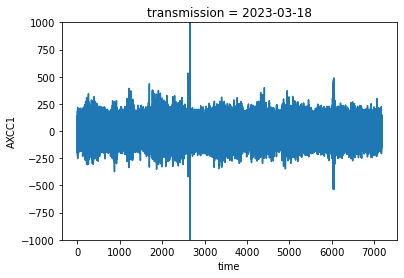

In [51]:
ds['AXCC1'].plot()
plt.ylim([-1000,1000])

In [71]:
urls = [fs.url(file) for file in files]

In [88]:
singles = []

for url in tqdm(urls[:2]):
    singles.append(kerchunk.hdf.SingleHdf5ToZarr(urls[0]).translate())

100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/it]


In [95]:
mzz = kerchunk.combine.MultiZarrToZarr(
    singles,
    remote_protocol="az",
    concat_dims=["transmission"]
)

In [103]:
storage_options = {
    'fo':singles[0],
    'remote_protocol':'az',
    'remote_options':dict(account_name=account_name)
}

z = zarr.open("reference://", storage_options=storage_options)

In [115]:
da = dask.array.from_zarr(z.AXBA1)
dax = xr.DataArray(da)